### Import Libraries and Data

In [1]:
import zipfile
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from datetime import datetime
import pytz
from tensorflow.keras.callbacks import LearningRateScheduler,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,Nadam
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
import random
from tqdm import tqdm
import shutil
import io
from nltk.translate.gleu_score import sentence_gleu
import pickle

In [2]:
final_df = pd.read_csv('final_df_preprocessed_2021111201.csv')

In [3]:
final_df = final_df[final_df['incorrect_word_count'] <= 12]
final_df.shape

(266487, 6)

In [4]:
final_df = final_df[['correct','incorrect']]

In [5]:
final_df[final_df.isna().any(axis=1)]

,correct,incorrect
14886,NaN,NaN
20290,NaN,this `` pen pal `` means simple friends
42611,NaN,NaN
45742,D,NaN
53063,NaN,NaN
57240,.,NaN
61930,NaN,I have studying
78316,NaN,June
142903,just kidding lol,NaN
151210,D,NaN


###  Train Test Split

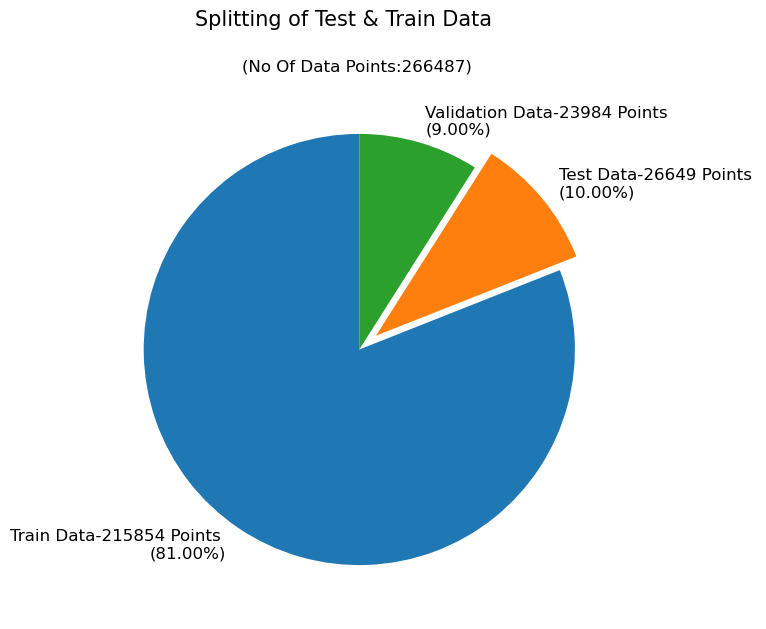

In [6]:
train,test = train_test_split(final_df, test_size=0.1,random_state=15)
train,validation = train_test_split(train, test_size=0.1)
fig,ax = plt.subplots(figsize =(10, 7))
labels_split = ['Train', 'Test','Validation'] 
sizes_split = [len(train),len(test),len(validation)]
pcts_split = [f'{l} Data-{s} Points \n({s*100/sum(sizes_split):.2f}%)' for s,l in zip(sizes_split, labels_split)] 
ax.pie(sizes_split, labels = pcts_split, startangle = 90, 
       explode=(0,0.1,0),textprops = {"fontsize":12} )

plt.suptitle(f'Splitting of Test & Train Data ', fontsize = 15)
plt.title(f'(No Of Data Points:{sum(sizes_split)}) ', fontsize = 12)
plt.show()

In [7]:
train['dec_correct_inp'] = '<start> ' + train['correct'].astype(str)
train['dec_correct_out'] = train['correct'].astype(str) + ' <end>'

validation['dec_correct_inp'] = '<start> ' + validation['correct'].astype(str)
validation['dec_correct_out'] = validation['correct'].astype(str) + ' <end>'

test['dec_correct_inp'] = '<start> ' + test['correct'].astype(str)
test['dec_correct_out'] = test['correct'].astype(str) + ' <end>'

In [8]:
train.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
81232,We are lookingtopromotion .,We are looking forword to thier promotion .,<start> We are lookingtopromotion .,We are lookingtopromotion . <end>
413197,"I do not have any classes today ,",I am not having any class today .,"<start> I do not have any classes today ,","I do not have any classes today , <end>"
132031,I am growing some vegetables .,I grow some vegetables .,<start> I am growing some vegetables .,I am growing some vegetables . <end>
50763,My second son is one year old .,My second son is one years old .,<start> My second son is one year old .,My second son is one year old . <end>
203804,But many other people want to use it too .,But many other people want to use it .,<start> But many other people want to use it t...,But many other people want to use it too . <end>


In [9]:
test.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
228514,Singing is a good way I can refresh .,Singing is the good way I can refresh .,<start> Singing is a good way I can refresh .,Singing is a good way I can refresh . <end>
481275,It would be too cold .,It must be too cold .,<start> It would be too cold .,It would be too cold . <end>
21243,I want one like a Muji note .,I want like Muji note .,<start> I want one like a Muji note .,I want one like a Muji note . <end>
385792,"Yesterday morning , I did not check a weather...","Yesterday morning , I did not check a wether ...","<start> Yesterday morning , I did not check a...","Yesterday morning , I did not check a weather..."
144880,"But , I will be very busy tomorrow .","But , I will be very busy tomorrow .","<start> But , I will be very busy tomorrow .","But , I will be very busy tomorrow . <end>"


In [10]:
validation.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
232177,Yesterday was my birthday !,yesterday was my birthday !,<start> Yesterday was my birthday !,Yesterday was my birthday ! <end>
121696,Title Summer,name Summer,<start> Title Summer,Title Summer <end>
334860,I have been there times .,I had a times to go there .,<start> I have been there times .,I have been there times . <end>
163662,He discovered the Fibonacci numbers .,He discovered Fibonacci number .,<start> He discovered the Fibonacci numbers .,He discovered the Fibonacci numbers . <end>
155048,I was happy to see them .,I am happy to see them .,<start> I was happy to see them .,I was happy to see them . <end>


In [12]:
train.to_csv('train_20211112.csv')
validation.to_csv('validation_20211112.csv')
test.to_csv('test_20211112.csv')

### Tokenizer

In [13]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['incorrect'].astype(str).values)

In [14]:
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_correct_inp'].astype(str).values)

In [15]:
vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)

Encoder words vocab size: 51869


In [16]:
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size::',vocab_size_dec)

Decoder words vocab size:: 43078


In [17]:
tokenizer_dec.word_index['<start>'],tokenizer_dec.word_index.get('<end>', None)

(1, None)

In [18]:
tokenizer_dec.word_index['<end>'] = max(tokenizer_dec.word_index.values()) + 1

In [22]:
with open('tokenizer_enc_20211112.pkl', 'wb') as f:
    pickle.dump(tokenizer_enc, f)

with open('tokenizer_dec_20211112.pkl', 'wb') as f:
    pickle.dump(tokenizer_dec, f)

In [23]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['incorrect'].astype(str).values)
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_correct_inp'].astype(str).values)

vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size::',vocab_size_dec)

tokenizer_dec.word_index['<start>'],tokenizer_dec.word_index.get('<end>', None)
tokenizer_dec.word_index['<end>'] = max(tokenizer_dec.word_index.values()) + 1

#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['incorrect'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['incorrect'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_correct_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

Encoder words vocab size: 51869
Decoder words vocab size:: 43078


### Text to Sequence

Mean Word Count:8.385075097056344


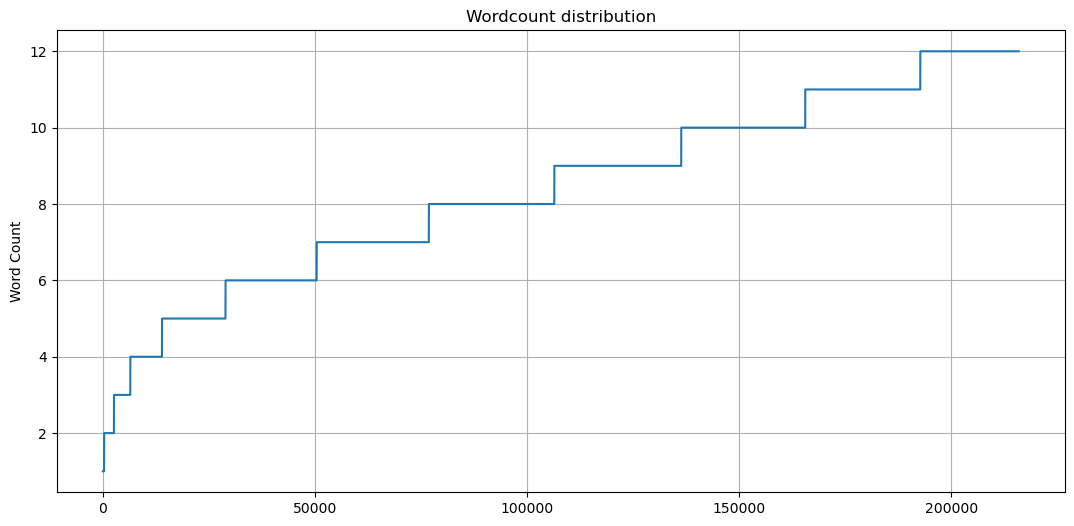

In [24]:
content=train['incorrect'].astype('str')
content_word_count=[len(content.iloc[i].split()) for i in range(len(content))]
mean_word_count=np.mean(content_word_count)
print(f'Mean Word Count:{mean_word_count}')
index=[i for i in range(0,len(content_word_count))]
fig, ax=plt.subplots(figsize=(13, 6))
plt.plot(index,sorted(content_word_count))
plt.grid()
plt.title("Wordcount distribution")
plt.ylabel("Word Count")
plt.show()

In [25]:
#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['incorrect'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['incorrect'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
test_enc_inp = pad_sequences(test_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

In [26]:
#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)
test_dec_inp = tokenizer_dec.texts_to_sequences(test['dec_correct_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_inp = pad_sequences(test_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

In [27]:
#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_correct_out'].astype(str).values)
test_dec_out = tokenizer_dec.texts_to_sequences(test['dec_correct_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_out = pad_sequences(test_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

In [29]:
with open('train_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(train_enc_inp, f)

with open('val_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(validation_enc_inp, f)

with open('test_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(test_enc_inp, f)

In [30]:
with open('train_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(train_dec_inp, f)

with open('val_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(validation_dec_inp, f)

with open('test_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(test_dec_inp, f)

In [31]:
with open('train_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(train_dec_out, f)

with open('val_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(validation_dec_out, f)

with open('test_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(test_dec_out, f)